In [1]:
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

## Load Training Data

In [2]:
def read_data(filename):
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    return data

In [39]:
train_file = 'data/train.json'
train_data = read_data(train_file)
print(len(train_data))

1604


## Prepare data

In [31]:
def find_minmax(data):
    mins = [min(min(item['band_1']), min(item['band_2'])) for item in data ]
    maxes = [max(max(item['band_1']), max(item['band_2'])) for item in data ]

    global_min = min(mins)
    global_max = max(maxes)
    
    return global_min, global_max

def find_minmax_angle(data):
    global_min  = min( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'  ])
    global_max = max( [item['inc_angle'] for item in data if item['inc_angle'] != 'na'])
  
    return global_min, global_max

def extract_image(data_item, key, min_value, max_value, image_size = 75):
    image = np.array(data_item[key])
    image = image.reshape(image_size, image_size)
   
    
    #img_mean = np.mean(image)
    #image = image - np.ones_like(image) * img_mean 
   
    image = (image - global_min) / (global_max - global_min)
   
    #img_mean = np.mean(image)
    #img_std = np.std(image)
    
    #image = image - np.ones_like(image) * img_mean 
    #image = image /  img_std
    
    #idx=((image > (img_mean - img_std / 2)) & (image < (img_mean + img_std / 2)))
    #image[idx]=0
    
    #image[0 : 10,:] = 0
    #image[65 : ,:] = 0
    #image[: , 0 : 10] = 0
    #image[:, 65 : ] = 0

    
    #image = cv2.GaussianBlur(image,(5,5),0)
    
    #image = (image * 255).astype(np.uint8)
    
    #clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(3,3)) 
    #image = clahe.apply(image)
    #image = (image / 255).astype(np.float)
    
    return image
    
def extract_images(data_item, min_value, max_value, image_size = 75):
    hh_image = extract_image(data_item, 'band_1', min_value, max_value, image_size)
    hv_image = extract_image(data_item, 'band_2', min_value, max_value, image_size)
    
    return hh_image, hv_image
     
def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [32]:
def prepare_dataset_ignore_angle(data, global_min, gobal_max):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        hh_image, hv_image = extract_images(item, global_min, gobal_max )
        image = np.dstack((hh_image, hv_image))
        X.append(image)
        if 'is_iceberg' in item.keys():
            labels.append(item['is_iceberg'])
        else:
            labels.append(0)
            
        ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)


def prepare_dataset_with_angle(data, global_min, gobal_max, angle_min, angle_max):
    X =[]
    labels = []
    ids = []
    
    for item in data:
        angle = item['inc_angle']
        if angle != 'na':
            hh_image, hv_image = extract_images(item, global_min, gobal_max )
            angle_layer = np.ones_like(hh_image) * (angle_max - angle) / (angle_max - angle_min) * 0.2
            image = np.dstack((hh_image, hv_image, angle_layer))
            X.append(image)
            if 'is_iceberg' in item.keys():
                labels.append(item['is_iceberg'])
            else:
                labels.append(0)

            ids.append(item['id'])
    return np.array(X), np.array(labels), np.array(ids)

In [33]:
def cut_image_part(data, margin):
    return data[:, margin : -margin, margin : - margin, :]

In [34]:
angle_min, angle_max = find_minmax_angle(train_data)

print(angle_min, angle_max)

24.7546 45.9375


-45.655499 34.574917


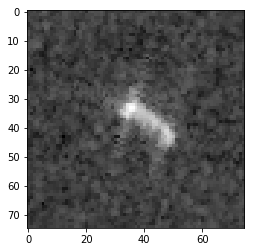

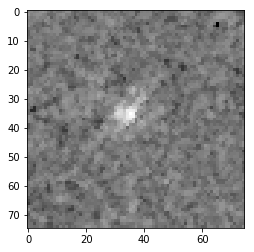

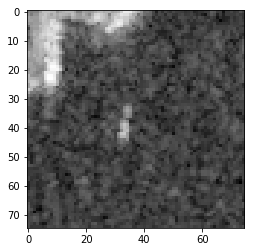

In [35]:
image_size = 75
global_min, global_max = find_minmax(train_data)

#X_train, y_train, _ = prepare_dataset_ignore_angle(train_data, global_min, global_max)
X_train, y_train, _ = prepare_dataset_with_angle(train_data, global_min, global_max, angle_min, angle_max)

print(global_min, global_max)


plt.imshow(X_train[24, :, :, 0], cmap='gray')
plt.show()

plt.imshow(X_train[25, :, :, 0], cmap='gray')
plt.show()

plt.imshow(X_train[26, :, :, 0], cmap='gray')
plt.show()


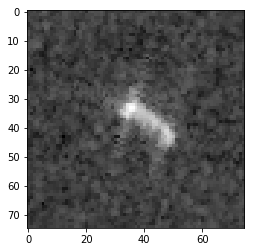

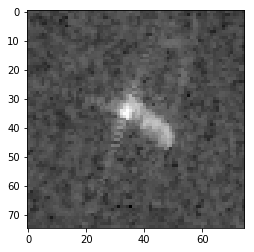

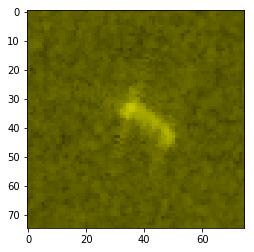

In [37]:
hh_image, hv_image = extract_images(train_data[24], global_min, global_max )
display_image(hh_image)
display_image(hv_image)

image = np.dstack((hh_image, hh_image, np.zeros_like(hv_image)))
plt.imshow(image)
plt.show()

(1471, 75, 75, 3)


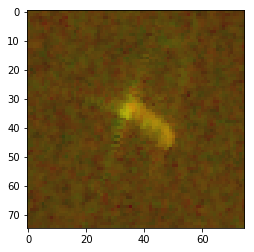

In [38]:
print(X_train.shape)

plt.imshow(X_train[24, :, :])
plt.show()


In [247]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [248]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=180, width_shift_range = 0.10, height_shift_range = 0.10, 
                             horizontal_flip = True, vertical_flip = True)
datagen.fit(X_train)

#X_train_new = np.copy(X_train)
#Y_train_new = np.copy(y_train)

#for i in range(40):
#    X_batch, y_batch =  next(datagen.flow(X_train, y_train, batch_size=2000))
#    if i == 0:
#        X_train_new = X_batch
#        Y_train_new = y_batch
#    else: 
#        X_train_new = np.concatenate((X_train_new, X_batch), axis=0)
#        Y_train_new = np.concatenate((Y_train_new, y_batch), axis=0)
    
    #plt.imshow(X_batch[24, :, :, 0])
    #plt.show()
                                    
    
#print(X_batch.shape)


#print (X_batch.shape)
##X_train = cut_image_part(X_train_new, 10)
#print (X_train_new.shape)







## Model

In [249]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.layers import Flatten, Dense
from keras.initializers import RandomNormal
from keras.regularizers import l2

entities_count = 20

def getModel10(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model


def getModel20(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [260]:
def getModel30(num_layers):
    activation = 'relu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel31(num_layers):
    activation = 'relu'
    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same',
                    input_shape=(75, 75, num_layers), use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=True,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(2048, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation=activation,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    return model

def getModel40(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False,
                     kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None), kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model



def getModel50(num_layers):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same',
                     input_shape=(75, 75, num_layers), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False,
                           kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation="relu",
                   kernel_initializer = RandomNormal(mean=0.0, stddev=0.02, seed=None)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))

    return model

In [261]:
model = getModel31(3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_209 (Conv2D)          (None, 75, 75, 16)        448       
_________________________________________________________________
activation_209 (Activation)  (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 75, 75, 16)        2320      
_________________________________________________________________
activation_210 (Activation)  (None, 75, 75, 16)        0         
_________________________________________________________________
max_pooling2d_203 (MaxPoolin (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 38, 38, 32)        4640      
_________________________________________________________________
activation_211 (Activation)  (None, 38, 38, 32)        0         
__________

In [262]:
from keras.callbacks import ModelCheckpoint  

epochs = 500
batch_size = 64


#train_tensors = X_train_new
#train_targets = Y_train_new

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

#res = model.fit(train_tensors, train_targets, 
#          validation_data = (X_valid, y_valid),
#          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

res = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = (X_valid, y_valid), verbose=1, callbacks=[checkpointer])


Epoch 1/500
17/16 [===============================] - 4s - loss: 0.6973 - acc: 0.5618 - val_loss: 0.6294 - val_acc: 0.6968
Epoch 2/500
17/16 [===============================] - 1s - loss: 0.6134 - acc: 0.6902 - val_loss: 0.6254 - val_acc: 0.6787
Epoch 3/500
17/16 [===============================] - 1s - loss: 0.5427 - acc: 0.7370 - val_loss: 0.5068 - val_acc: 0.7692
Epoch 4/500
17/16 [===============================] - 1s - loss: 0.4390 - acc: 0.8027 - val_loss: 0.3773 - val_acc: 0.8507
Epoch 5/500
17/16 [===============================] - 1s - loss: 0.4847 - acc: 0.7913 - val_loss: 0.3845 - val_acc: 0.8484
Epoch 6/500
17/16 [===============================] - 1s - loss: 0.4381 - acc: 0.8210 - val_loss: 0.3568 - val_acc: 0.8575
Epoch 7/500
17/16 [===============================] - 1s - loss: 0.5337 - acc: 0.7507 - val_loss: 0.5137 - val_acc: 0.7941
Epoch 8/500
17/16 [===============================] - 1s - loss: 0.4508 - acc: 0.8064 - val_loss: 0.3863 - val_acc: 0.8348
Epoch 9/500
17/1

17/16 [===============================] - 1s - loss: 0.3595 - acc: 0.8495 - val_loss: 0.2975 - val_acc: 0.8846
Epoch 66/500
17/16 [===============================] - 1s - loss: 0.3003 - acc: 0.8661 - val_loss: 0.3003 - val_acc: 0.8824
Epoch 67/500
17/16 [===============================] - 1s - loss: 0.2976 - acc: 0.8754 - val_loss: 0.2956 - val_acc: 0.8665
Epoch 68/500
17/16 [===============================] - 1s - loss: 0.3138 - acc: 0.8737 - val_loss: 0.3343 - val_acc: 0.8552
Epoch 69/500
17/16 [===============================] - 1s - loss: 0.3110 - acc: 0.8737 - val_loss: 0.3110 - val_acc: 0.8665
Epoch 70/500
17/16 [===============================] - 1s - loss: 0.3061 - acc: 0.8838 - val_loss: 0.2894 - val_acc: 0.8710
Epoch 71/500
17/16 [===============================] - 1s - loss: 0.3198 - acc: 0.8589 - val_loss: 0.2886 - val_acc: 0.8824
Epoch 72/500
17/16 [===============================] - 1s - loss: 0.3051 - acc: 0.8791 - val_loss: 0.2748 - val_acc: 0.8959
Epoch 73/500
17/16 [=

C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.294664). Check your callbacks.
  % delta_t_median)
C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148081). Check your callbacks.
  % delta_t_median)


17/16 [===============================] - 1s - loss: 0.2948 - acc: 0.8883 - val_loss: 0.2438 - val_acc: 0.8914
Epoch 81/500
17/16 [===============================] - 1s - loss: 0.3288 - acc: 0.8828 - val_loss: 0.5229 - val_acc: 0.7534
Epoch 82/500
17/16 [===============================] - 1s - loss: 0.5987 - acc: 0.7354 - val_loss: 0.8783 - val_acc: 0.6222
Epoch 83/500
17/16 [===============================] - 1s - loss: 0.4985 - acc: 0.8027 - val_loss: 0.4974 - val_acc: 0.8326
Epoch 84/500
17/16 [===============================] - 1s - loss: 0.4621 - acc: 0.8063 - val_loss: 0.4644 - val_acc: 0.8258
Epoch 85/500
17/16 [===============================] - 1s - loss: 0.4188 - acc: 0.8238 - val_loss: 0.3235 - val_acc: 0.8484
Epoch 86/500
17/16 [===============================] - 1s - loss: 0.4107 - acc: 0.8329 - val_loss: 0.3513 - val_acc: 0.8620
Epoch 87/500
17/16 [===============================] - 1s - loss: 0.4379 - acc: 0.8109 - val_loss: 0.4150 - val_acc: 0.8145
Epoch 88/500
17/16 [=

17/16 [===============================] - 1s - loss: 0.2523 - acc: 0.9078 - val_loss: 0.2417 - val_acc: 0.9072
Epoch 148/500
17/16 [===============================] - 1s - loss: 0.2878 - acc: 0.8856 - val_loss: 0.2454 - val_acc: 0.8959
Epoch 149/500
17/16 [===============================] - 1s - loss: 0.2619 - acc: 0.8902 - val_loss: 0.2538 - val_acc: 0.8846
Epoch 150/500
17/16 [===============================] - 1s - loss: 0.2814 - acc: 0.8856 - val_loss: 0.2943 - val_acc: 0.8665
Epoch 151/500
17/16 [===============================] - 1s - loss: 0.3063 - acc: 0.8783 - val_loss: 0.2539 - val_acc: 0.9005
Epoch 152/500
17/16 [===============================] - 1s - loss: 0.2638 - acc: 0.8884 - val_loss: 0.2963 - val_acc: 0.8756
Epoch 153/500
17/16 [===============================] - 1s - loss: 0.2837 - acc: 0.8957 - val_loss: 0.3069 - val_acc: 0.8529
Epoch 154/500
17/16 [===============================] - 1s - loss: 0.3117 - acc: 0.8680 - val_loss: 0.4019 - val_acc: 0.8439
Epoch 155/500


17/16 [===============================] - 1s - loss: 0.2509 - acc: 0.9041 - val_loss: 0.2458 - val_acc: 0.9005
Epoch 215/500
17/16 [===============================] - 1s - loss: 0.2562 - acc: 0.8986 - val_loss: 0.2706 - val_acc: 0.8756
Epoch 216/500
17/16 [===============================] - 1s - loss: 0.2406 - acc: 0.9060 - val_loss: 0.3517 - val_acc: 0.8484
Epoch 217/500
17/16 [===============================] - 1s - loss: 0.2368 - acc: 0.9087 - val_loss: 0.3123 - val_acc: 0.8710
Epoch 218/500
17/16 [===============================] - 1s - loss: 0.2493 - acc: 0.9012 - val_loss: 0.3375 - val_acc: 0.8665
Epoch 219/500
17/16 [===============================] - 1s - loss: 0.2396 - acc: 0.9032 - val_loss: 0.2928 - val_acc: 0.8846
Epoch 220/500
17/16 [===============================] - 1s - loss: 0.2529 - acc: 0.9068 - val_loss: 0.2495 - val_acc: 0.8982
Epoch 221/500
17/16 [===============================] - 1s - loss: 0.2460 - acc: 0.9142 - val_loss: 0.2750 - val_acc: 0.8846
Epoch 222/500


17/16 [===============================] - 1s - loss: 0.2179 - acc: 0.9170 - val_loss: 0.2581 - val_acc: 0.8891
Epoch 283/500
17/16 [===============================] - 1s - loss: 0.2194 - acc: 0.9189 - val_loss: 0.2777 - val_acc: 0.8801
Epoch 284/500
17/16 [===============================] - 1s - loss: 0.2397 - acc: 0.9132 - val_loss: 0.2469 - val_acc: 0.8869
Epoch 285/500
17/16 [===============================] - 1s - loss: 0.2769 - acc: 0.8790 - val_loss: 0.3241 - val_acc: 0.8507
Epoch 286/500
17/16 [===============================] - 1s - loss: 0.2318 - acc: 0.9032 - val_loss: 0.2724 - val_acc: 0.8982
Epoch 287/500
17/16 [===============================] - 1s - loss: 0.2251 - acc: 0.9207 - val_loss: 0.3317 - val_acc: 0.8552
Epoch 288/500
17/16 [===============================] - 1s - loss: 0.2479 - acc: 0.9041 - val_loss: 0.2779 - val_acc: 0.8937
Epoch 289/500
17/16 [===============================] - 1s - loss: 0.2110 - acc: 0.9124 - val_loss: 0.2519 - val_acc: 0.9050
Epoch 290/500


17/16 [===============================] - 1s - loss: 0.2193 - acc: 0.9095 - val_loss: 0.2729 - val_acc: 0.8891
Epoch 350/500
17/16 [===============================] - 1s - loss: 0.2456 - acc: 0.9124 - val_loss: 0.2672 - val_acc: 0.9027
Epoch 351/500
17/16 [===============================] - 1s - loss: 0.2132 - acc: 0.9115 - val_loss: 0.2604 - val_acc: 0.8891
Epoch 352/500
17/16 [===============================] - 1s - loss: 0.2142 - acc: 0.9152 - val_loss: 0.3024 - val_acc: 0.8891
Epoch 353/500
17/16 [===============================] - 1s - loss: 0.2109 - acc: 0.9198 - val_loss: 0.2872 - val_acc: 0.8937
Epoch 354/500
17/16 [===============================] - 1s - loss: 0.2013 - acc: 0.9179 - val_loss: 0.3039 - val_acc: 0.8756
Epoch 355/500
17/16 [===============================] - 1s - loss: 0.2272 - acc: 0.9123 - val_loss: 0.2738 - val_acc: 0.8937
Epoch 356/500
17/16 [===============================] - 1s - loss: 0.2619 - acc: 0.8984 - val_loss: 0.3063 - val_acc: 0.8824
Epoch 357/500


17/16 [===============================] - 1s - loss: 0.1998 - acc: 0.9253 - val_loss: 0.2446 - val_acc: 0.9140
Epoch 418/500
17/16 [===============================] - 1s - loss: 0.2346 - acc: 0.8956 - val_loss: 0.2618 - val_acc: 0.9118
Epoch 419/500
17/16 [===============================] - 1s - loss: 0.2906 - acc: 0.8883 - val_loss: 0.2652 - val_acc: 0.8914
Epoch 420/500
17/16 [===============================] - 1s - loss: 0.2953 - acc: 0.8847 - val_loss: 0.2710 - val_acc: 0.9050
Epoch 421/500
17/16 [===============================] - 1s - loss: 0.2181 - acc: 0.9216 - val_loss: 0.2692 - val_acc: 0.9005
Epoch 422/500
17/16 [===============================] - 1s - loss: 0.1864 - acc: 0.9160 - val_loss: 0.3144 - val_acc: 0.8846
Epoch 423/500
17/16 [===============================] - 1s - loss: 0.2332 - acc: 0.9142 - val_loss: 0.3034 - val_acc: 0.8937
Epoch 424/500
17/16 [===============================] - 1s - loss: 0.2130 - acc: 0.9179 - val_loss: 0.2792 - val_acc: 0.8801
Epoch 425/500


C:\Users\Alexey\AppData\Local\conda\conda\envs\aind-cv\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145502). Check your callbacks.
  % delta_t_median)


17/16 [===============================] - 1s - loss: 0.2317 - acc: 0.9086 - val_loss: 0.2925 - val_acc: 0.8959
Epoch 485/500
17/16 [===============================] - 1s - loss: 0.2157 - acc: 0.9216 - val_loss: 0.2601 - val_acc: 0.9095
Epoch 486/500
17/16 [===============================] - 1s - loss: 0.2062 - acc: 0.9142 - val_loss: 0.2380 - val_acc: 0.8937
Epoch 487/500
17/16 [===============================] - 1s - loss: 0.2012 - acc: 0.9197 - val_loss: 0.2557 - val_acc: 0.9050
Epoch 488/500
17/16 [===============================] - 1s - loss: 0.1813 - acc: 0.9327 - val_loss: 0.2520 - val_acc: 0.9118
Epoch 489/500
17/16 [===============================] - 1s - loss: 0.1999 - acc: 0.9308 - val_loss: 0.2617 - val_acc: 0.9005
Epoch 490/500
17/16 [===============================] - 1s - loss: 0.1863 - acc: 0.9234 - val_loss: 0.2727 - val_acc: 0.8959
Epoch 491/500
17/16 [===============================] - 1s - loss: 0.2384 - acc: 0.9133 - val_loss: 0.3255 - val_acc: 0.8665
Epoch 492/500


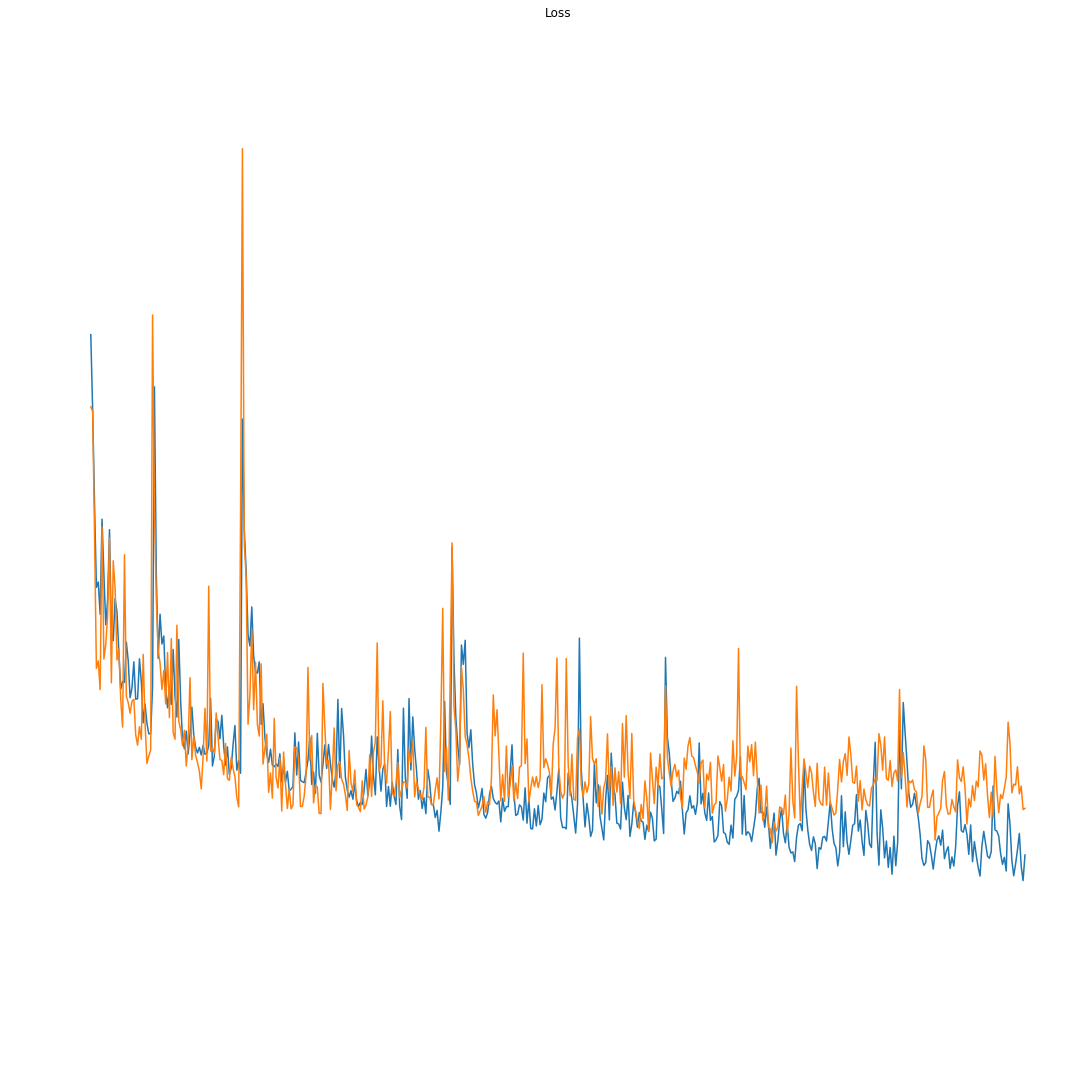

In [264]:
graphs = [res]

fig = plt.figure(figsize = (15, 15))
plt.axis('off')
plt.tight_layout()

for i, hist in enumerate(graphs):
    ax1 = fig.add_subplot(110 + i + 1)
    #plt.setp([ax1], xticks=[], yticks=[])
    ax1.set_ylim(0, 1.0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("Loss")
    ax1.set_ylabel('loss')
    #ax1.set_xlabel('epoch')
    ax1.plot(hist.history['loss'])
    ax1.plot(hist.history['val_loss'])
    ax1.xaxis.set_ticks(np.arange(0, epochs, epochs // 10))
    ax1.yaxis.set_ticks(np.arange(0, 1, 0.2))


In [265]:
from keras.models import load_model

prediction_model = load_model('saved_models/weights.best.from_scratch.hdf5')


In [266]:
test_file = 'data/test.json'
test_data = read_data(test_file)


In [267]:
#X_test, y_test, ids = prepare_dataset_ignore_angle(test_data, global_min, global_max)
X_test, y_test, ids = prepare_dataset_with_angle(test_data, global_min, global_max, angle_min, angle_max)

In [268]:
print(X_test.shape)

(8424, 75, 75, 3)


In [269]:
res = prediction_model.predict(X_test)

In [270]:
print(res.shape)

(8424, 1)


In [271]:
print(y_test.shape)

(8424,)


In [272]:
print(y_test)

[0 0 0 ..., 0 0 0]


In [273]:
import csv
headers = ['id', 'is_iceberg']

with open('results.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile, quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(headers)

    for prediction, item_id in zip(res, ids):
        csv_writer.writerow([item_id, np.asscalar(prediction)])

    